Copyright Rigetti Computing 2021.

## Grover's search algorithm in pyQuil

In this notebook, we'll demonstrate a simple implementation of Grover's algorithm in pyQuil.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import numpy as np
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.quil import Program
from typing import List

First, we write the circuit that defines the oracle for a given bitstring. We use an ancillary qubit in the state $\vert - \rangle = \frac{1}{\sqrt{2}}\left(\vert 0 \rangle - \vert 1 \rangle \right)$ to perform a "phase kick-back", i.e. $ U_{\omega} \vert x \rangle \vert - \rangle = (-1)^{f(x)} \vert x \rangle \vert - \rangle$. Moreover, we can identify the marked bitstring simply by controlled operations.

In [2]:
def oracle(bb: str, qubits: List[int]) -> Program:
    '''
    Implements the oracle U:|x>|-> --> (-1)^(f(x)) |x>|->
    where |-> = (|0> - |1>)/sqrt(2) and f(x) is either 0 or 1
    
    :param bb: Unique bitstring for which f(x) = 1
    :param qubits: List of qubits to run the computation on,
        with the last qubit acting as the ancillary
    '''
    assert len(qubits) - 1 == len(bb), f"Not enough qubits"
    prog = Program()
    # track qubits which are controlled on the 0 state
    flipped_idxs = []
    for q, x in enumerate(bb):
        if x=='0':
            prog += X(qubits[q])
            flipped_idxs.append(q)
        elif x=='1':
            pass
        else:
            raise ValueError("Input should be a bitstring in str format.")
    # perform the phase kick-back controlled on the marked bitstring
    prog += X(qubits[-1]).controlled(qubits[:-1])
    # flip qubits back to the their former state
    for q in flipped_idxs:
        prog += X(qubits[q])
    return prog

Second, we define the circuit for the diffusion operator $U_{+} = 2 \vert + \rangle \langle + \vert - \mathbb{I}$. We first move to the Hadamard basis, then apply a controlled phase kick-back similarly as above.

In [3]:
def diffusion(qubits: List[int]) -> Program:
    '''
    Implements the diffusion operator U = 2|+><+| - I

    :param qubits: List of qubits to run the computation on,
        with the last qubit acting as the ancillary
    '''
    # move to the Hadamard basis
    prog = Program([H(q) for q in qubits])
    # phase kick-back controlled on the |0>^n state
    prog += Program([X(q) for q in qubits])
    prog += X(qubits[-1]).controlled(qubits[:-1])
    prog += Program([X(q) for q in qubits])
    # move back to the computational basis
    prog += Program([H(q) for q in qubits])
    return prog

Putting these two things together, we can run Grover's algorithm for some marked bitstring.

Marked bitstring is: 10010
The most probable outcome is: |10010>


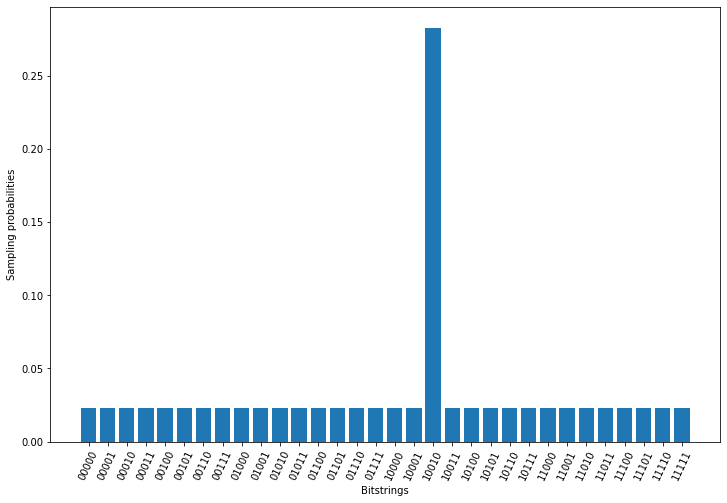

In [4]:
# number of qubits (excluding the ancilla)
n = 5

# define a "marked bitstring"
marked_str = ''.join(np.random.choice(['0', '1'], size=n))
print(f"Marked bitstring is: {marked_str}")

# number of iterations, only go up to sqrt(2^n) iterations
num_iters = int(np.sqrt(2**n))

# reversed because of WavefunctionSimulator convention
qubits = list(reversed(range(len(marked_str) + 1)))

### write the full circuit
# initialize n qubits in the |+> state, and an ancilla in the |-> state
prog = Program()
ro = prog.declare('ro', 'BIT', 1)
prog += Program([H(q) for q in qubits])
prog += Z(qubits[-1])

# define the oracle and phase shift operators
orac = oracle(marked_str, qubits)
diff = diffusion(qubits)

# call the oracle and the phase shift operators in succession
# a total of sqrt(2^n) times
for _ in range(num_iters):
    prog += orac
    prog += diff
    
# measure out and discard the ancilla
prog += MEASURE(qubits[-1], ro[0])

# simulate exact probabilities via the WavefunctionSimulator
wfn_sim = WavefunctionSimulator()
wfn = wfn_sim.wavefunction(prog)
outcome_probs = wfn.get_outcome_probs()
print ("The most probable outcome is: |%s>" % (max(outcome_probs, key=outcome_probs.get)[:-1]))

# plot histogram of sampling probabilities
plt.figure(figsize=(12, 8))
plt.bar([i[:-1] for i in outcome_probs.keys()], outcome_probs.values())
plt.xticks(fontsize=10, rotation=65)
plt.xlabel('Bitstrings')
plt.ylabel('Sampling probabilities')
plt.show()